**TODO:**
- stop the search efficiency curves when they locate the top performing COF
    - cap with a marker "*"
- there seems to be something wrong with the indexing between the SFBO and the MFBO. 
    - MFBO seems to have an additional +1 incremented reletive to the SFBO

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns

sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})

<Figure size 432x288 with 0 Axes>

## Load Data

In [2]:
###
#  features and molecular simulation data
###
file = h5py.File("targets_and_normalized_features.jld2", "r")
# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) # ... Needs to be tensor?
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]

# total number of COFs in data set
nb_COFs = X.shape[0]

In [3]:
###
#  bayesian optimization data
###
# dict_keys(['acquired_set', 'cost_acquired', 
#            'nb_COFs_initialization', 'BO_iter_top_cof_acquired'])
mfbo_res = pickle.load(open('search_results/mfbo_results_with_EI.pkl', 'rb'))

# dict_keys(['ids_acquired', 'y_acquired', 'cost_acquired', 
#            'nb_COFs_initialization', 'BO_iter_top_cof_acquired'])
sfbo_res = pickle.load(open('search_results/sfbo_results_with_EI.pkl', 'rb'))

# dict_keys(['ids_acquired', 'y_rs_max_mu', 'y_rs_max_sig_bot', 'y_rs_max_sig_top', 'cost_acquired'])
random_search_res = pickle.load(open('search_results/random_search_results.pkl', 'rb'))

nb_COFs_initialization = mfbo_res['nb_COFs_initialization']
nb_iters = len(mfbo_res['acquired_set'])

assert len(sfbo_res['ids_acquired']) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_iters
assert sfbo_res['nb_COFs_initialization'] == nb_COFs_initialization

## Search Efficientcy Curves

In [4]:
###
#  accumulated cost lags the index of the cost_acquired (iteration COF is identified) by 1
###

# cost_acquired = sfbo_res['cost_acquired']
# accumulated_cost = np.zeros(len(cost_acquired))

# accumulated_cost[0] = 0

# accumulated_cost[1] = cost_acquired[0]

# accumulated_cost[2] = cost_acquired[0] + cost_acquired[1]

# accumulated_cost[3] = cost_acquired[0] + cost_acquired[1] + cost_acquired[2]


def accumulated_cost(cost_acquired):
    accumulated_cost = np.zeros(len(cost_acquired))
    accumulated_cost[0] = cost_acquired[0]
    for i in range(1, len(cost_acquired)):
        accumulated_cost[i] = accumulated_cost[i-1] + cost_acquired[i]
    return accumulated_cost

In [5]:
def y_max_acquired(res, search_type):
    if search_type == "SFBO":
        y_acquired = res['y_acquired']
        nb_iters = len(y_acquired) # =50
        return [max(y_acquired[:i+1]) for i in range(nb_iters)]      
    
    if search_type == "MFBO":
        nb_iters = len(res['acquired_set'])
        y_maxes = np.zeros(nb_iters)
        # we want the maximum y value (only high-fidelity) up to a given iteration
        y_max = 0.0 # update this each iteration.
        for i, (f_id, cof_id) in enumerate(res['acquired_set']):
            y_acq_this_iter = y[f_id][cof_id]
            # i is iteration index
            if f_id == 1 and y_acq_this_iter > y_max:
                y_max = y_acq_this_iter # over-write max
            y_maxes[i] = y_max 
        return y_maxes

In [6]:
# for i in range(3, 10): 
#     print(i) # res: 3, 4, 5, 6, 7, 8, 9
    
# len(range(3, 10)) # res: 7

SFBO
2
21
MFBO
5
46


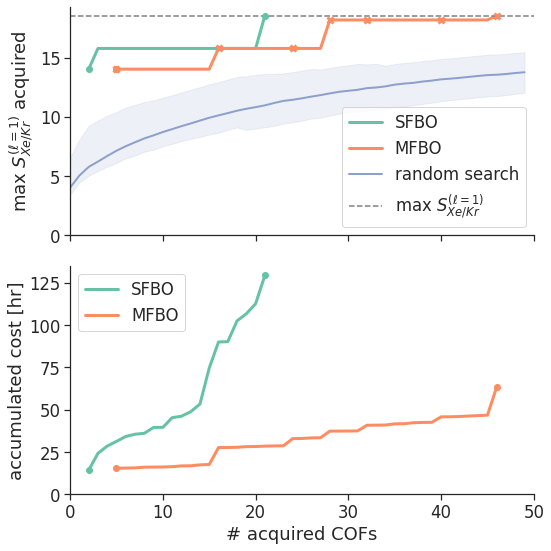

In [7]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))  
markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) -1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = res['BO_iter_top_cof_acquired'] # SFBO: 21, MFBO: 46
    print(iter_top_cof_acquired)
    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
#     iter_range = np.array(range(iter_top_cof_acquired)) 
    
    ###
    #  accumulated cost
    #     - index lags by 1
    ###
    acc_cost = accumulated_cost(res['cost_acquired']) / 60 # convert to hours
    ax[1].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               acc_cost[iter_start:iter_top_cof_acquired+1], label=search_type, color=color)
    
    ax[1].scatter([iter_start], [acc_cost[iter_start]], color=color, marker="o")
    ax[1].scatter([iter_top_cof_acquired], [acc_cost[iter_top_cof_acquired]], 
                  color=color, marker="o")
#     ax[1].fill_between(iter_range[:iter_top_cof_acquired-iter_start], 
#                        np.zeros(iter_top_cof_acquired-iter_start) / 60, 
#                        acc_cost[iter_start:][:iter_top_cof_acquired-iter_start] / 60)
    
    ###
    #  search efficiency curves
    ###
    y_max_at_iter = y_max_acquired(res, search_type)
    ax[0].plot(iter_range[iter_start:iter_top_cof_acquired+1], 
               y_max_at_iter[iter_start:iter_top_cof_acquired+1], 
               label=search_type, color=color)
    if search_type == "SFBO":
        ax[0].scatter([iter_top_cof_acquired], y_max_at_iter[iter_top_cof_acquired+1], 
                      color=color, marker="o", zorder=100)
    if search_type == "MFBO":
        fidelities = mfbo_res['acquired_set'][:, 0][iter_start:iter_top_cof_acquired+1] == 1
        for f_id in [1]:
            ax[0].scatter(iter_range[iter_start:iter_top_cof_acquired+1][fidelities], 
                          y_max_at_iter[iter_start:iter_top_cof_acquired+1][fidelities], 
                          color=color, marker=markers[f_id], zorder=100)
    ax[0].scatter([iter_start], [y_max_at_iter[iter_start]], color=color, marker="o")


###
#  random search (SFBO, l=1)
###
ax[0].plot(range(len(random_search_res['y_rs_max_mu'])), random_search_res['y_rs_max_mu'], 
           label="random search", lw=2, color="C2")

ax[0].fill_between(range(len(random_search_res['y_rs_max_mu'])), 
                   random_search_res['y_rs_max_mu'] - random_search_res['y_rs_max_sig_bot'], 
                   random_search_res['y_rs_max_mu'] + random_search_res['y_rs_max_sig_top'], 
                   alpha=0.15, color="C2")

###
#  global maximum
###
ax[0].axhline(y=max(y[1]), label="max $S^{(\ell=1)}_{Xe/Kr}$", color="gray", ls="--", lw=1.5)

###
#  axis settings
###
ax[0].set_xlim(xmin=0, xmax=nb_iters)
ax[0].set_ylabel("max $S^{(\ell=1)}_{Xe/Kr}$ acquired")
ax[0].legend(loc='lower right')
# ax[0].set_ylim(ymin=0, ymax=35000)
ax[1].set_ylabel("accumulated cost [hr]")
ax[1].legend(loc='upper left')
ax[1].set_xlabel("# acquired COFs")

ax[1].set_ylim(ymin=0)
ax[0].set_ylim(ymin=0)

plt.tight_layout()
sns.despine()
plt.savefig("./figs/MFBO_cost_and_search_efficiency.pdf", format="pdf")
plt.show()

## Pirinciple Component Analysis

In [8]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)
# [0.5 for i = 1:n]

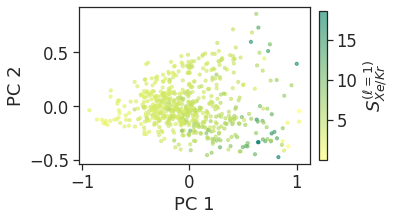

In [9]:
cmap_name = cm.summer_r # sequential colormaps: spring, summer, autumn, viridis, Wistia, hot, copper

fig = plt.figure()
#low dimensional (PCA) visualization of the entire dataset
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")
plt.xticks()
plt.yticks()

plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
# plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", dpi=600, format="pdf")
plt.show()

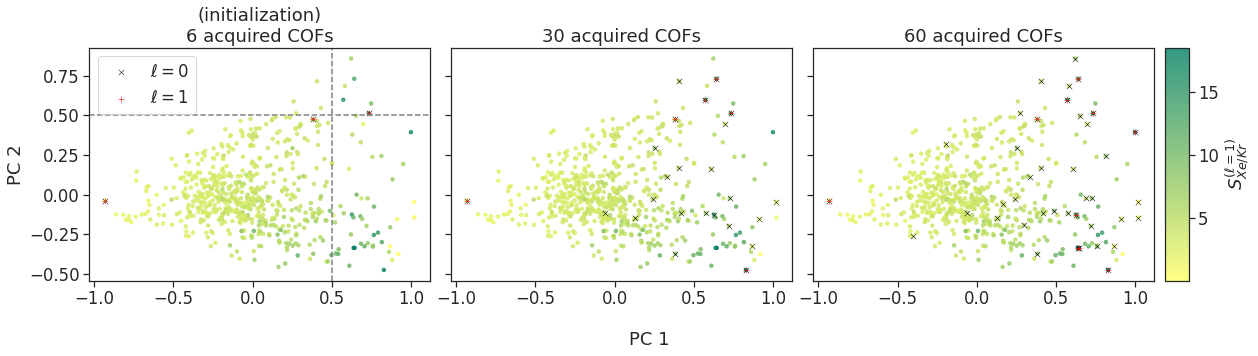

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid


nb_acquired = [2*nb_COFs_initialization, 30, 60]

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1, 3),
                 axes_pad=0.3,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][:nb]
    lf_acq = acq[acq[:, 0] == 0, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == 1, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)
    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=12, alpha=0.8) 
    
    ### 
    # plot center of feature space
    ###
    if i == 0:
        ax.axhline(y=0.5, color="gray", ls="--", lw=1.5)
        ax.axvline(x=0.5, color="gray", ls="--", lw=1.5)
        
    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1], 0], X_2D[lf_acq[:nb, 1], 1], 
                  label="$\ell=0$",
                  color='k', marker='x', s=30, lw=0.5) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1], 0], X_2D[hf_acq[:nb, 1], 1], 
               label="$\ell=1$",
               color='r', marker='+', s=30, lw=0.5, zorder=1)
    
    # subplot titles
    if i == 0:
        ax.set_title('(initialization)\n{} acquired COFs'.format(nb_acquired[i]))
    else:
        ax.set_title('{} acquired COFs'.format(nb_acquired[i]))
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
cb.set_label(label="$S^{(\ell=1)}_{Xe/Kr}$")

###
#  axis commands
###
grid[0].legend()
grid[0].set_ylabel('PC 2')
    
fig.text(0.52, -0.02, 'PC 1', ha='center')
# fig.tight_layout()
plt.savefig("./figs/MFBO_PCA_multiple_iterations.pdf", bbox_inches="tight", dpi=600, format="pdf")
plt.show()

In [11]:
# hm... which is the first in the acquired set? is it actualy the closes to the center of feature space?